In [1]:

# Set up notebook
%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

# load libraries
from FRVRS import nu, fu
from numpy import nan
from pandas import (
    CategoricalDtype, DataFrame, Index, NaT, Series, concat, get_dummies, isna, notnull, read_csv, read_excel, to_datetime, to_numeric
)
from re import split, search, sub, MULTILINE
from scipy.stats import f_oneway, ttest_ind, kruskal, norm
import itertools
import os.path as osp
import re
import statsmodels.api as sm


## Use the CSV Data from the Last Successful Build

In [3]:

# load the CSV data frame from the last successful build
data_frames_dict = nu.load_data_frames(
    verbose=True, metrics_evaluation_open_world_csv_stats_df20240516=''
)
csv_stats_df = data_frames_dict['metrics_evaluation_open_world_csv_stats_df20240516'].copy()
print(csv_stats_df.shape)
print(sorted([cn for cn in csv_stats_df.columns if 'partici' in cn]))

No pickle exists for metrics_evaluation_open_world_csv_stats_df20240516 - attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/metrics_evaluation_open_world_csv_stats_df20240516.csv.
(158663, 125)
['participant_id']



### Truncate the CSV data to only include our patients at the times they were engaged

In [4]:

# Build a dataset of each CSV file and the action tick where CACI patients first appear
desert_patients_list = [
    'Open World Marine 1 Female Root', 'Open World Marine 2 Male Root', 'Open World Civilian 1 Male Root', 'Open World Civilian 2 Female Root'
]
jungle_patients_list = [
    'Open World Marine 1 Male Root', 'Open World Marine 2 Female Root', 'Open World Marine 3 Male Root', 'Open World Marine 4 Male Root'
]
submarine_patients_list = ['Navy Soldier 1 Male Root', 'Navy Soldier 2 Male Root', 'Navy Soldier 3 Male Root', 'Navy Soldier 4 Female Root']
urban_patients_list = ['Marine 1 Male Root', 'Marine 2 Male Root', 'Marine 3 Male Root', 'Marine 4 Male Root', 'Civilian 1 Female Root']
patients_set = set(desert_patients_list + jungle_patients_list + submarine_patients_list + urban_patients_list)
mask_series = csv_stats_df.patient_id.isin(patients_set)
rows_list = []
for csv_file_name, csv_file_name_df in csv_stats_df[mask_series].groupby('csv_file_name'):
    row_dict = {'csv_file_name': csv_file_name}
    action_tick = csv_file_name_df.action_tick.min()
    row_dict['first_occurence'] = action_tick
    rows_list.append(row_dict)
first_occurence_df = DataFrame(rows_list)
print(first_occurence_df.shape)

(51, 2)


In [5]:

# From each file, filter out the time before the first appearance of the CACI patients
truncated_df = DataFrame([])
for (csv_file_name, first_occurence), _ in first_occurence_df.groupby(['csv_file_name', 'first_occurence']):
    mask_series = (csv_stats_df.csv_file_name == csv_file_name) & (csv_stats_df.action_tick >= first_occurence)
    df = csv_stats_df[mask_series]
    truncated_df = concat([truncated_df, df], axis='index')
print(truncated_df.shape)

(137063, 125)


In [6]:

# Create a list of patients that CACI doesn't care about
mask_series = ~csv_stats_df.patient_id.isin(patients_set) & ~csv_stats_df.patient_id.isnull()
non_patients_list = csv_stats_df[mask_series].patient_id.unique().tolist()
non_patients_list

['patient U Root', 'patient V Root', 'patient W Root', 'patient X Root', 'electrician Root', 'bystander Root', 'Simulation Root', 'Patient V Root', 'Patient U Root', 'Patient W Root', 'Adept Victim Root', 'Adept Shooter Root', 'Patient X Root', 'NPC 2 Root', 'NPC 1 Root', 'NPC 3 Root', 'NPC 4 Root', 'US Soldier 1 Root', 'Local Soldier 1 Root', 'Civilian 1 Root', 'NPC Root', 'Civilian 2 Root']

In [7]:

# Filter out just the patients that CACI doesn't care about
mask_series = ~truncated_df.patient_id.isin(non_patients_list)
truncated_df = truncated_df[mask_series]
print(truncated_df.shape)

(124203, 125)



## Create the Scene Data

In [8]:

# Create the scene data frame precursor
distance_delta_df = fu.get_distance_deltas_data_frame(truncated_df)
print(distance_delta_df.shape)

(67, 17)


In [9]:

# Create the scene stats data frame
rows_list = []
for (session_uuid, scene_id), idx_df in distance_delta_df.groupby(fu.scene_groupby_columns):
    row_dict = list(idx_df.T.to_dict().values())[0]
    
    # mean_patient_count
    patient_count = row_dict.pop('patient_count')
    row_dict.update({'scene_patient_count': patient_count})
    
    # Get the whole scene history
    mask_series = True
    for cn in fu.scene_groupby_columns: mask_series &= (truncated_df[cn] == eval(cn))
    scene_df = truncated_df[mask_series]
    
    if scene_df.shape[0]:
        row_dict['participant_id'] = scene_df.participant_id.iloc[0]
        
        # Get the count of all the patient injuries
        all_patient_injuries_count = 0
        for patient_id, patient_df in scene_df.groupby('patient_id'):
            all_patient_injuries_count += patient_df.injury_id.nunique()
        row_dict['scene_patient_injuries_count'] = all_patient_injuries_count
        
        # percent_injury_correctly_treated
        correctly_treated_count = fu.get_injury_correctly_treated_count(scene_df)
        row_dict['scene_correctly_treated_count'] = correctly_treated_count
        try: percent_injury_correctly_treated = 100 * correctly_treated_count / all_patient_injuries_count
        except ZeroDivisionError: percent_injury_correctly_treated = nan
        row_dict['scene_percent_injury_correctly_treated'] = percent_injury_correctly_treated
        
        # mean_pulse_taken_count
        pulse_taken_count = fu.get_pulse_taken_count(scene_df)
        row_dict['scene_pulse_taken_count'] = pulse_taken_count
        
        # mean_stills_value
        row_dict['scene_stills_value'] = fu.get_stills_value(scene_df)
        
        # mean_teleport_count
        row_dict['scene_teleport_count'] = fu.get_teleport_count(scene_df)
        
        # mean_time_to_hemorrhage_control_per_patient
        row_dict['scene_time_to_hemorrhage_control_per_patient'] = fu.get_time_to_hemorrhage_control_per_patient(scene_df)
        
        # mean_triage_time
        row_dict['scene_triage_time'] = fu.get_triage_time(scene_df)
        
        # mean_percent_accurate_tagging
        # total_action_count
        mask_series = scene_df.action_type.isin(fu.action_types_list)
        row_dict['scene_action_count'] = scene_df[mask_series].shape[0]
        
        # total_assessment_count
        mask_series = scene_df.action_type.isin(['PATIENT_ENGAGED', 'PULSE_TAKEN'])
        row_dict['scene_assessment_count'] = scene_df[mask_series].shape[0]
        
        # total_treatment_count
        mask_series = scene_df.action_type.isin(['INJURY_TREATED'])
        row_dict['scene_treatment_count'] = scene_df[mask_series].shape[0]
        
        # total_tag_application_count
        mask_series = scene_df.action_type.isin(['TAG_APPLIED'])
        row_dict['scene_tag_application_count'] = scene_df[mask_series].shape[0]
        
        # treated_expectant_count
    
    rows_list.append(row_dict)
scene_stats_df = DataFrame(rows_list).drop_duplicates()
print(scene_stats_df.shape)

(67, 30)


In [10]:

# Add the encounter layout column
new_column_name = 'encounter_layout'
encounter_layouts_list = ['Desert', 'Jungle', 'Submarine', 'Urban']
for (session_uuid, scene_id), scene_df in csv_stats_df.groupby(fu.scene_groupby_columns):
    for env_str in encounter_layouts_list:
        patients_list = eval(f'{env_str.lower()}_patients_list')
        if all(map(lambda patient_id: patient_id in scene_df.patient_id.unique().tolist(), patients_list)):
            mask_series = (scene_stats_df.session_uuid == session_uuid) & (scene_stats_df.scene_id == scene_id)
            scene_stats_df.loc[mask_series, new_column_name] = env_str
print(scene_stats_df.groupby(new_column_name, dropna=False).size().to_frame().rename(columns={0: 'record_count'}))

                  record_count
encounter_layout              
Desert                      15
Jungle                      13
Submarine                   13
Urban                       13
NaN                         13



### Add the mean % accurate tagging column

In [11]:

# Create the tag-to-SALT data frame
tag_to_salt_df = fu.get_is_tag_correct_data_frame(truncated_df, groupby_column='participant_id')

In [12]:

# Get the percentage tag correct counts for each scene for each group
correct_count_by_tag_df = fu.get_percentage_tag_correct_data_frame(tag_to_salt_df, groupby_column='participant_id')

In [13]:

# Group the scene stats by participant ID to get the tagging accuracy measure
for participant_id, idx_df in scene_stats_df.groupby('participant_id'):
    
    # mean_percent_accurate_tagging
    mask_series = (correct_count_by_tag_df.participant_id == participant_id)
    scene_stats_df.loc[idx_df.index, 'mean_percent_accurate_tagging'] = correct_count_by_tag_df[mask_series].percentage_tag_correct.mean()


### Add the treated-expectant count column

In [14]:

# Loop through each patient to build the max salt and treated-expectant measures
rows_list = []
for (session_uuid, scene_id, patient_id), patient_df in truncated_df.groupby(fu.patient_groupby_columns):
    row_dict = {cn: eval(cn) for cn in fu.patient_groupby_columns}
    row_dict['max_salt'] = fu.get_max_salt(patient_df, session_uuid=session_uuid, scene_id=scene_id, random_patient_id=patient_id)[1]
    if (row_dict['max_salt'] == 'EXPECTANT'):
        mask_series = ~patient_df.injury_treated_required_procedure.isnull() | ~patient_df.tool_applied_type.isnull()
        row_dict['treated_expectant'] = {True: 'yes', False: 'no'}[mask_series.any()]
    else: row_dict['treated_expectant'] = nan
    rows_list.append(row_dict)
treated_expectant_df = DataFrame(rows_list)

In [15]:

# Loop through each scene to build the treated-expectant counts
for (session_uuid, scene_id), scene_df in treated_expectant_df.groupby(fu.scene_groupby_columns):
    mask_series = (scene_df.treated_expectant == 'yes')
    
    # treated_expectant_count
    treated_expectant_count = mask_series.sum()
    mask_series = (scene_stats_df.session_uuid == session_uuid) & (scene_stats_df.scene_id == scene_id)
    scene_stats_df.loc[mask_series, 'treated_expectant_count'] = treated_expectant_count

In [16]:

# Add the survey columns
survey_columns = ['AD_KDMA_Sim', 'AD_KDMA_Text', 'PropTrust', 'ST_KDMA_Sim', 'ST_KDMA_Text']
if any(map(lambda x: x not in scene_stats_df.columns, survey_columns)):
    file_path = osp.join(nu.data_folder, 'xlsx', 'participant_data_0420.xlsx')
    participant_data_df = read_excel(file_path).rename(columns={'ParticipantID': 'participant_id'})
    
    print("\nColumns to merge the participant data with the scene stats on:")
    on_columns = sorted(set(scene_stats_df.columns).intersection(set(participant_data_df.columns)))
    assert on_columns, "You have nothing to merge the participant dataset with the scene stats on"
    print(on_columns)

    print("\nThe participant data columns we want to have in the merge:")
    survey_set = set(on_columns + survey_columns)
    all_set = set(participant_data_df.columns)
    assert survey_set.issubset(all_set), f"You're missing {survey_set.difference(all_set)} from participant_data_0420.xlsx"
    columns_list = sorted(survey_set)
    print(columns_list)
    
    # mean_AD_KDMA_Sim
    # mean_AD_KDMA_Text
    # mean_PropTrust
    # mean_ST_KDMA_Sim
    # mean_ST_KDMA_Text
    scene_stats_df = scene_stats_df.merge(participant_data_df[columns_list], how='left', on=on_columns)


Columns to merge the participant data with the scene stats on:
['participant_id']

The participant data columns we want to have in the merge:
['AD_KDMA_Sim', 'AD_KDMA_Text', 'PropTrust', 'ST_KDMA_Sim', 'ST_KDMA_Text', 'participant_id']



### Truncate the scene data to only include our patients at the times they were engaged

In [17]:

# Filter out the unnamed layouts
mask_series = scene_stats_df.encounter_layout.isin(encounter_layouts_list)
pre_count = scene_stats_df.shape[0]
scene_stats_df = scene_stats_df[mask_series]
print(f"\nFiltered out {pre_count - scene_stats_df.shape[0]} unnamed encounter layouts")


Filtered out 13 unnamed encounter layouts


In [18]:

# Check for zero teleports
mask_series = (scene_stats_df.scene_teleport_count < 1)
print(f"\nThere are {scene_stats_df[mask_series].shape[0]} out of {scene_stats_df.shape[0]} scenes with no teleports")


There are 0 out of 54 scenes with no teleports


In [19]:

# Save the scene stats dataset
nu.save_data_frames(truncated_scene_stats_df=scene_stats_df, verbose=True)

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/truncated_scene_stats_df.csv



## Create the ANOVA Dataframe

In [20]:

# Get the columns to merge the scene stats dataset with the CSV stats on
print("\nColumns to merge the scene stats dataset with the CSV stats on:")
on_columns = sorted(set(csv_stats_df.columns).intersection(set(scene_stats_df.columns)))
print(on_columns)


Columns to merge the scene stats dataset with the CSV stats on:
['participant_id', 'scene_id', 'session_uuid']


In [21]:

# Get the scene stats dataset columns we want to have in the merge
print('\nThe scene stats dataset columns we want to have in the merge:')
mean_analysis_columns = sorted([
    'scene_percent_injury_correctly_treated', 'scene_pulse_taken_count', 'scene_stills_value', 'scene_teleport_count',
    'scene_time_to_hemorrhage_control_per_patient', 'scene_triage_time', 'scene_patient_count', 'mean_percent_accurate_tagging'
] + survey_columns)
sum_analysis_columns = sorted([
    'scene_action_count', 'scene_assessment_count', 'scene_treatment_count', 'scene_tag_application_count', 'treated_expectant_count'
])
analysis_set = set(mean_analysis_columns + sum_analysis_columns)
all_set = set(scene_stats_df.columns)
assert analysis_set.issubset(all_set), f"You're missing {analysis_set.difference(all_set)} from your analysis_columns"
print(analysis_set)


The scene stats dataset columns we want to have in the merge:
{'scene_treatment_count', 'AD_KDMA_Sim', 'mean_percent_accurate_tagging', 'scene_patient_count', 'scene_tag_application_count', 'ST_KDMA_Sim', 'scene_triage_time', 'treated_expectant_count', 'scene_time_to_hemorrhage_control_per_patient', 'ST_KDMA_Text', 'scene_percent_injury_correctly_treated', 'AD_KDMA_Text', 'PropTrust', 'scene_pulse_taken_count', 'scene_stills_value', 'scene_teleport_count', 'scene_action_count', 'scene_assessment_count'}


In [22]:

# Merge the scene stats with the CSV stats
print("\nMerge the scene stats with the CSV stats")
columns_list = on_columns + mean_analysis_columns + sum_analysis_columns
assert set(columns_list).issubset(set(scene_stats_df.columns)), "You've lost access to the analysis columns"
merge_df = csv_stats_df.merge(scene_stats_df[columns_list], on=on_columns, how='left').drop_duplicates()


Merge the scene stats with the CSV stats


In [23]:

# Get the merge dataset columns we want to have in the groupby
print('\nThe merge dataset columns we want to have in the groupby:')
columns_list = sorted(set(
    on_columns + mean_analysis_columns + sum_analysis_columns
).intersection(set(merge_df.columns)))
print(columns_list)


The merge dataset columns we want to have in the groupby:
['AD_KDMA_Sim', 'AD_KDMA_Text', 'PropTrust', 'ST_KDMA_Sim', 'ST_KDMA_Text', 'mean_percent_accurate_tagging', 'participant_id', 'scene_action_count', 'scene_assessment_count', 'scene_id', 'scene_patient_count', 'scene_percent_injury_correctly_treated', 'scene_pulse_taken_count', 'scene_stills_value', 'scene_tag_application_count', 'scene_teleport_count', 'scene_time_to_hemorrhage_control_per_patient', 'scene_treatment_count', 'scene_triage_time', 'session_uuid', 'treated_expectant_count']


In [24]:

# Get the numeric columns we want to take the mean of
print("\nThe numeric columns we want to take the mean of:")
df = merge_df[on_columns + mean_analysis_columns]
assert set(df.columns).issubset(set(merge_df.columns)), "You've lost access to the mean analysis columns"
mean_numeric_columns = sorted(set(nu.get_numeric_columns(df)).difference(set(
    on_columns
)))
print(mean_numeric_columns)


The numeric columns we want to take the mean of:
['AD_KDMA_Sim', 'AD_KDMA_Text', 'PropTrust', 'ST_KDMA_Sim', 'ST_KDMA_Text', 'mean_percent_accurate_tagging', 'scene_patient_count', 'scene_percent_injury_correctly_treated', 'scene_pulse_taken_count', 'scene_stills_value', 'scene_teleport_count', 'scene_time_to_hemorrhage_control_per_patient', 'scene_triage_time']


In [25]:

# Get the numeric columns we want to take the sum of
print("\nThe numeric columns we want to take the sum of:")
df = merge_df[on_columns + sum_analysis_columns]
assert set(df.columns).issubset(set(merge_df.columns)), "You've lost access to the sum analysis columns"
sum_numeric_columns = sorted(set(nu.get_numeric_columns(df)).difference(set(
    on_columns
)))
print(sum_numeric_columns)


The numeric columns we want to take the sum of:
['scene_action_count', 'scene_assessment_count', 'scene_tag_application_count', 'scene_treatment_count', 'treated_expectant_count']


In [26]:

# Get the other columns we do not want to take the mean or sum of
print("\nThe other columns we do not want to take the mean or sum of:")
other_columns = sorted(set(on_columns + mean_analysis_columns + sum_analysis_columns).difference(set(
    mean_numeric_columns + sum_numeric_columns
)))
print(other_columns)


The other columns we do not want to take the mean or sum of:
['participant_id', 'scene_id', 'session_uuid']


In [27]:

# Get the means and sums datasets and the columns to merge the summed half of the merge with the meaned half of the merge on
means_df = merge_df[mean_numeric_columns+on_columns].groupby(on_columns).mean().reset_index(drop=False).rename(
    columns={cn: 'mean_'+cn.replace('mean_', '').replace('scene_', '') for cn in mean_numeric_columns}
).dropna(axis='columns', how='all')
sums_df = merge_df[sum_numeric_columns+on_columns].groupby(on_columns).sum().reset_index(drop=False).rename(
    columns={cn: 'sum_'+cn.replace('sum_', '').replace('scene_', '') for cn in sum_numeric_columns}
).dropna(axis='columns', how='all')
print("\nColumns to merge the summed half of the merge with the meaned half of the merge on:")
on_columns = sorted(set(means_df.columns).intersection(set(sums_df.columns)))
print(on_columns)
left_df = means_df.merge(sums_df, on=on_columns, how='outer').drop_duplicates()


Columns to merge the summed half of the merge with the meaned half of the merge on:
['participant_id', 'scene_id', 'session_uuid']


In [28]:

# Get the columns to merge the unaggregated half of the merge with the aggregated half of the merge on
right_df = merge_df[other_columns].drop_duplicates().dropna(axis='columns', how='all')
print("\nColumns to merge the unaggregated half of the merge with the aggregated half of the merge on:")
on_columns = sorted(set(left_df.columns).intersection(set(right_df.columns)))
print(on_columns)


Columns to merge the unaggregated half of the merge with the aggregated half of the merge on:
['participant_id', 'scene_id', 'session_uuid']


In [29]:

# Merge the unaggregated half of the merge with the aggregated half
print(
    "\nAggregate the data from the merged datasets and group by participant, session,"
    " and scene to get the means and sums of the numeric columns"
)
anova_df = left_df.merge(right_df, on=on_columns, how='outer').drop_duplicates()
assert set(
    ['mean_'+cn for cn in survey_columns]
).issubset(set(anova_df.columns)), "You've lost acces to the survey columns (PropTrust, et al)"
assert len(anova_df.groupby(
    ['participant_id', 'scene_id', 'session_uuid']
).groups.keys()) == anova_df.shape[0], "You have duplicate rows in anova_df"


Aggregate the data from the merged datasets and group by participant, session, and scene to get the means and sums of the numeric columns


In [30]:

# Add the sim environment back in
print("\nAdd the sim environment back in")
new_column = 'encounter_layout'
on_columns = sorted(set(anova_df.columns).intersection(set(scene_stats_df.columns)))
columns_list = on_columns + [new_column]
assert set(columns_list).issubset(set(scene_stats_df.columns)), f"You've lost acces to the {new_column} column"
anova_df = anova_df.merge(
    scene_stats_df[columns_list], on=on_columns, how='left'
)
print(anova_df.groupby(new_column).size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
).head(5))


Add the sim environment back in
                  record_count
encounter_layout              
Desert                      15
Jungle                      13
Submarine                   13
Urban                       13


In [31]:

# Check for low patient counts
mask_series = (anova_df.mean_patient_count < 4)
print(f"\nThere are {anova_df[mask_series].shape[0]} out of {anova_df.shape[0]} participations with low patient counts")


There are 0 out of 68 participations with low patient counts


In [32]:

# Store the results
columns_list = anova_df.columns.tolist()
nu.save_data_frames(truncated_anova_df=anova_df[columns_list], verbose=True)

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/truncated_anova_df.csv


In [33]:

# Formally describe the analytic columns
columns_list = ['mean_'+cn for cn in survey_columns] + [
    'mean_percent_accurate_tagging', 'mean_patient_count', 'mean_percent_injury_correctly_treated', 'mean_pulse_taken_count',
    'mean_stills_value', 'mean_teleport_count', 'mean_time_to_hemorrhage_control_per_patient', 'mean_triage_time',
    'sum_action_count', 'sum_assessment_count', 'sum_tag_application_count', 'sum_treatment_count', 'sum_treated_expectant_count'
]
anova_df[columns_list].describe().T

,count,mean,std,min,25%,50%,75%,max
mean_AD_KDMA_Sim,54.0,4.229938e-01,1.081691e-01,0.175000,0.341667,4.416667e-01,4.750000e-01,8.000000e-01
mean_AD_KDMA_Text,54.0,4.083333e-01,9.269718e-02,0.141667,0.366667,4.166667e-01,4.666667e-01,6.250000e-01
mean_PropTrust,51.0,3.627451e+00,9.058993e-01,0.000000,3.666667,4.000000e+00,4.000000e+00,4.333333e+00
mean_ST_KDMA_Sim,54.0,5.524821e-01,6.101352e-02,0.361538,0.530528,5.538462e-01,5.955128e-01,6.433566e-01
mean_ST_KDMA_Text,54.0,3.778463e-01,8.540882e-02,0.222553,0.312732,3.809398e-01,4.315112e-01,5.691236e-01
mean_percent_accurate_tagging,54.0,3.111111e+01,2.030003e+01,0.000000,12.625000,2.875000e+01,4.250000e+01,7.500000e+01
mean_patient_count,54.0,4.240741e+00,4.315477e-01,4.000000,4.000000,4.000000e+00,4.000000e+00,5.000000e+00
mean_percent_injury_correctly_treated,52.0,3.726908e+01,2.654799e+01,0.000000,13.621795,4.006410e+01,5.785714e+01,8.500000e+01
mean_pulse_taken_count,54.0,8.111111e+00,7.642154e+00,0.000000,2.000000,6.000000e+00,1.175000e+01,2.600000e+01
mean_stills_value,54.0,6.851852e-01,4.688031e-01,0.000000,0.000000,1.000000e+00,1.000000e+00,1.000000e+00


In [40]:

# Get statistics using OSU format
columns_list = ['mean_'+cn for cn in survey_columns] + [
    'mean_percent_accurate_tagging', 'mean_patient_count', 'mean_percent_injury_correctly_treated', 'mean_pulse_taken_count',
    'mean_stills_value', 'mean_teleport_count', 'mean_time_to_hemorrhage_control_per_patient', 'mean_triage_time',
    'sum_action_count', 'sum_assessment_count', 'sum_tag_application_count', 'sum_treatment_count', 'sum_treated_expectant_count'
]
description_df = nu.get_statistics(anova_df, columns_list).T

# Calculate range and IQR
description_df['range'] = description_df['max'] - description_df['min']
description_df['IQR'] = description_df['75%'] - description_df['25%']

# Define the index list
index_list = ['min', 'median', 'max', 'IQR', 'range', 'mean', 'SD']

# Set formatting to prevent scientific notation (assuming numeric columns)
description_df = description_df[index_list].applymap('{:.4f}'.format)  # Format as floats with 4 decimals

# Display the DataFrame subset
nu.save_data_frames(description_df=description_df, verbose=True)
display(description_df)

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/description_df.csv


,min,median,max,IQR,range,mean,SD
mean_AD_KDMA_Sim,0.1750,0.4417,0.8000,0.1333,0.6250,0.4230,0.1082
mean_AD_KDMA_Text,0.1417,0.4167,0.6250,0.1000,0.4833,0.4083,0.0927
mean_PropTrust,0.0000,4.0000,4.3333,0.3333,4.3333,3.6275,0.9059
mean_ST_KDMA_Sim,0.3615,0.5538,0.6434,0.0650,0.2818,0.5525,0.0610
mean_ST_KDMA_Text,0.2226,0.3809,0.5691,0.1188,0.3466,0.3778,0.0854
mean_percent_accurate_tagging,0.0000,28.7500,75.0000,29.8750,75.0000,31.1111,20.3000
mean_patient_count,4.0000,4.0000,5.0000,0.0000,1.0000,4.2407,0.4315
mean_percent_injury_correctly_treated,0.0000,40.0641,85.0000,44.2353,85.0000,37.2691,26.5480
mean_pulse_taken_count,0.0000,6.0000,26.0000,9.7500,26.0000,8.1111,7.6422
mean_stills_value,0.0000,1.0000,1.0000,1.0000,1.0000,0.6852,0.4688



# Plot the Correlations

In [25]:

# Define a means to plot a correlation graph
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt

def plot_correlation_graph(correlations, title_str='Correlation Matrix of ??', ax=None):
    
    # Plotting the correlation matrix using matplotlib
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    cmap = plt.get_cmap('coolwarm')
    norm = colors.Normalize(vmin=-1, vmax=1)

    # Create the heatmap
    cax = ax.matshow(correlations, cmap=cmap, norm=norm)

    # Add a color bar
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(correlations.columns)))
    ax.set_yticks(np.arange(len(correlations.columns)))
    ax.set_xticklabels(correlations.columns)
    ax.set_yticklabels(correlations.columns)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')

    # Add text annotations.
    for (i, j), val in np.ndenumerate(correlations):
        ax.text(j, i, f'{val:.3f}', ha='center', va='center', color='black', fontsize=48/correlations.shape[0])
    plt.title(title_str)
    plt.show()

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/correlations_df.csv


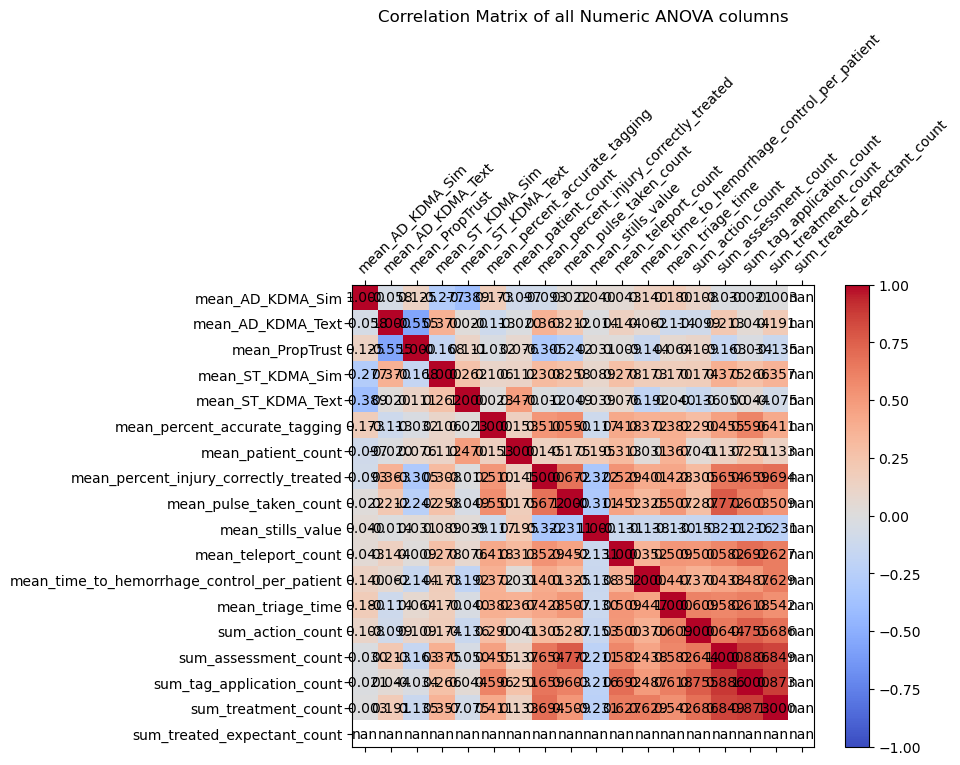

In [38]:

# Plot the correlations of all the numeric columns in the ANOVA dataset
columns_list = ['mean_'+cn for cn in survey_columns] + [
    'mean_percent_accurate_tagging', 'mean_patient_count', 'mean_percent_injury_correctly_treated', 'mean_pulse_taken_count',
    'mean_stills_value', 'mean_teleport_count', 'mean_time_to_hemorrhage_control_per_patient', 'mean_triage_time',
    'sum_action_count', 'sum_assessment_count', 'sum_tag_application_count', 'sum_treatment_count', 'sum_treated_expectant_count'
]
# columns_list = ['mean_'+cn for cn in survey_columns]
df = anova_df[columns_list]
correlations_df = df.corr().round(3)
nu.save_data_frames(correlations_df=correlations_df, verbose=True)
plot_correlation_graph(correlations_df, title_str=f"Correlation Matrix of all Numeric ANOVA columns")

In [ ]:
raise


----

In [ ]:

# Check for miscalculated injury columns
assert (
    scene_stats_df.all_patient_injuries_count == scene_stats_df[
        ['injury_correctly_treated_count', 'injury_not_treated_count', 'injury_wrongly_treated_count']
    ].sum(axis='columns')
).all(), "The sum of the various injury counts does not match the total injury count for all rows."

In [ ]:

new_column_name = 'scene_type'
if (new_column_name in scene_stats_df.columns): scene_stats_df = scene_stats_df.drop(columns=new_column_name)
if (new_column_name not in scene_stats_df.columns): scene_stats_df[new_column_name] = 'Triage'
column_value = 'Orientation'
if (column_value not in scene_stats_df.scene_type):
    for (session_uuid, scene_id), scene_df in csv_stats_df.groupby(fu.scene_groupby_columns):
        patients_list = sorted(scene_df[~scene_df.patient_id.isnull()].patient_id.unique())
        is_mike_series = Series(patients_list).map(lambda x: 'mike' in str(x).lower())
        if is_mike_series.all():
            mask_series = True
            for cn in fu.scene_groupby_columns: mask_series &= (scene_stats_df[cn] == eval(cn))
            scene_stats_df.loc[mask_series, new_column_name] = column_value
    display(
        scene_stats_df.groupby([new_column_name]).size().to_frame().rename(
            columns={0: 'record_count'}
        ).sort_values(new_column_name, ascending=False).head(20)
    )

In [ ]:

new_column_name = 'is_scene_aborted'
if (new_column_name not in scene_stats_df.columns):
    
    # 1 second = 1,000 milliseconds; 1 minute = 60 seconds
    scene_stats_df[new_column_name] = False
    for (session_uuid, scene_id), scene_df in csv_stats_df.groupby(fu.scene_groupby_columns):
        mask_series = True
        for cn in fu.scene_groupby_columns: mask_series &= (scene_stats_df[cn] == eval(cn))
        scene_stats_df.loc[mask_series, new_column_name] = fu.get_is_scene_aborted(scene_df)
print(scene_stats_df.groupby(new_column_name).size().to_frame().rename(columns={0: 'record_count'}))

In [ ]:

scene_columns_set = set(scene_stats_df.columns)
logs_columns_set = set(csv_stats_df.columns)
intersection_columns = set(['is_scene_aborted'])

drop_columns = sorted(scene_columns_set.intersection(logs_columns_set).intersection(intersection_columns))
if drop_columns:
    print("\nDrop the logs columns already recorded in the scene stats data frames")
    print(drop_columns)
    csv_stats_df = csv_stats_df.drop(columns=drop_columns)

columns_list = ['encounter_layout', 'scene_type', 'teleport_count']
display(
    scene_stats_df[columns_list].groupby(columns_list, dropna=False).size().to_frame().rename(
        columns={0: 'record_count'}
    ).sort_values(columns_list, ascending=[False]*len(columns_list))
)

In [ ]:

mask_series = scene_stats_df.scene_type.isin(['Orientation'])
pre_count = scene_stats_df.shape[0]
scene_stats_df = scene_stats_df[~mask_series]
print(f"\nFiltered out {pre_count - scene_stats_df.shape[0]} orientation scenes")

In [ ]:

print("\nBreak up the metadata columns into their own columns")
metadata_columns = sorted([cn for cn in merge_df.columns if cn.endswith('_metadata')])
for cn in metadata_columns:
    str_prefix = split('_metadata', cn, 0)[0]
    
    # Split the pipe-delimited values into a DataFrame
    split_df = merge_df[cn].str.split('|', expand=True)
    
    # Change the column names to reflect the content
    split_df.columns = [
        f'{str_prefix}_patient_id', f'{str_prefix}_engagement_start', f'{str_prefix}_location_tuple', f'{str_prefix}_patient_sort',
        f'{str_prefix}_predicted_priority', f'{str_prefix}_injury_severity'
    ]
    
    # Make engagement_start an integer
    # split_df[f'{str_prefix}_engagement_start'] = split_df[f'{str_prefix}_engagement_start'].fillna(0).astype(int)
    split_df[f'{str_prefix}_engagement_start'] = to_numeric(split_df[f'{str_prefix}_engagement_start'], errors='coerce')
    
    # Add the split columns to the original DataFrame
    merge_df = concat([merge_df, split_df], axis='columns')
    
    # Drop the original column
    merge_df = merge_df.drop(columns=[cn, f'{str_prefix}_predicted_priority'])

In [ ]:

patient_id_columns = sorted([cn for cn in merge_df.columns if cn.endswith('_patient_id')])
engagement_start_columns = sorted([cn for cn in merge_df.columns if cn.endswith('_engagement_start')])
location_tuple_columns = sorted([cn for cn in merge_df.columns if cn.endswith('_location_tuple')])
patient_sort_columns = sorted([cn for cn in merge_df.columns if cn.endswith('_patient_sort')])
injury_severity_columns = sorted([cn for cn in merge_df.columns if cn.endswith('_injury_severity')])

In [ ]:

new_column_name = 'prioritize_high_injury_severity_patients'
if injury_severity_columns and (new_column_name not in merge_df.columns):
    print("\nAdd the prioritize patients columns")
    prioritize_columns = [new_column_name]
    merge_df[new_column_name] = 0
    def f(srs):
        is_maxed = nan
        injury_severity_list = []
        for column_name, column_value in srs.iteritems():
            if column_name.endswith('_injury_severity') and not isna(column_value):
                injury_severity_list.append(column_value)
        if injury_severity_list:
            is_maxed = int(srs.engaged_patient00_injury_severity == max(injury_severity_list))
        return is_maxed
    merge_df[new_column_name] = merge_df.apply(f, axis='columns')
    print(merge_df.groupby(new_column_name, dropna=False).size().to_frame().rename(columns={0: 'record_count'}))

In [ ]:

print("\nAdd medical role back in")
new_column = 'MedRole'
column_name = 'medical_role'
if new_column in scene_stats_df.columns:
    on_columns = sorted(set(anova_df.columns).intersection(set(scene_stats_df.columns)))
    columns_list = on_columns + [new_column]
    anova_df = anova_df.merge(
        scene_stats_df[columns_list], on=on_columns, how='left'
    ).rename(columns={new_column: column_name})
    anova_df[column_name] = anova_df[column_name].map(
        lambda cv: get_value_description('MedRole', cv)
    ).replace('', nan)
print(anova_df.groupby(column_name).size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
).head(5))

In [ ]:

dfs_list = [fn for fn in dir() if fn.endswith('_df')]
columns_list = []
df_columns_dict = {}
for df_name in dfs_list:
    df_columns_list = eval(f'{df_name}.columns.tolist()')
    columns_list.extend(df_columns_list)
    df_columns_dict[df_name] = df_columns_list
columns_set = set(columns_list)

In [ ]:

variables_list = """mean_AD_KDMA_Sim
mean_AD_KDMA_Text
mean_PropTrust
mean_ST_KDMA_Sim
mean_ST_KDMA_Text
percent_injury_correctly_treated
mean_pulse_taken_count
mean_stills_value
mean_teleport_count
mean_time_to_hemorrhage_control_per_patient
mean_triage_time
mean_patient_count
mean_percent_accurate_tagging
total_action_count
total_assessment_count
total_treatment_count
total_tag_application_count
treated_expectant_count""".split('\n')
needed_variables_list = []
for variable_name in variables_list:
    if variable_name not in columns_set:
        needed_variables_list.append(variable_name)

In [ ]:

needed_variables_list

In [ ]:

unsort_dict = {}
for df_name, columns_list in df_columns_dict.items():
    for column_name in columns_list:
        df_name_set = unsort_dict.get(column_name, set())
        df_name_set.add(df_name)
        unsort_dict[column_name] = df_name_set
for variable_name in sorted(set(variables_list).difference(set(needed_variables_list))):
    hasit_set = unsort_dict.get(variable_name, set())
    print(variable_name, hasit_set)

In [ ]:

[cn for cn in columns_set if ('injury' in str(cn)) and ('correct' in str(cn))]

In [ ]:

[cn for cn in columns_set if ('injury' in str(cn)) and ('correct' not in str(cn)) and ('count' in str(cn))]

In [ ]:

[cn for cn in columns_set if ('percent' in str(cn))]

In [ ]:

[cn for cn in columns_set if ('total' in str(cn))]

In [ ]:

for participant_id, participant_df in anova_df.groupby('participant_id'):
    
    # mean_AD_KDMA_Sim
    mean_AD_KDMA_Sim = participant_df.mean_AD_KDMA_Sim.mean()
    
    # mean_AD_KDMA_Text
    mean_AD_KDMA_Text = participant_df.mean_AD_KDMA_Text.mean()
    
    # mean_PropTrust
    mean_PropTrust = participant_df.mean_PropTrust.mean()
    
    # mean_ST_KDMA_Sim
    mean_ST_KDMA_Sim = participant_df.mean_ST_KDMA_Sim.mean()
    
    # mean_ST_KDMA_Text
    mean_ST_KDMA_Text = participant_df.mean_ST_KDMA_Text.mean()
    
    # percent_injury_correctly_treated
    total_injury_count = len(triage_paper_df[base_mask_series].groupby(fu.injury_groupby_columns).groups)
    fu.get_injury_not_treated_count(scene_df)
    fu.get_injury_correctly_treated_count(scene_df)
    fu.get_injury_wrongly_treated_count(scene_df)
    percent_injury_correctly_treated = 100 * correctly_treated_count / total_count
    
    # mean_pulse_taken_count
    mean_pulse_taken_count = participant_df.mean_pulse_taken_count.mean()
    
    # mean_stills_value
    mean_stills_value = participant_df.mean_stills_value.mean()
    
    # mean_teleport_count
    mean_teleport_count = participant_df.mean_teleport_count.mean()
    
    # mean_time_to_hemorrhage_control_per_patient
    mean_time_to_hemorrhage_control_per_patient = participant_df.mean_time_to_hemorrhage_control_per_patient.mean()
    
    # mean_triage_time
    mean_triage_time = participant_df.mean_triage_time.mean()
    
    # mean_patient_count
    mean_patient_count = participant_df.mean_patient_count.mean()
    
    # mean_percent_accurate_tagging
    mask_series = (correct_count_by_tag_df.participant_id == participant_id)
    row_dict['mean_percent_accurate_tagging'] = correct_count_by_tag_df[mask_series].percentage_tag_correct.mean()
    
    # total_action_count
    mask_series = participant_df.action_type.isin(self.action_types_list)
    row_dict['action_count'] = participant_df[mask_series].shape[0]
    row_dict['total_action_count'] = scene_df.action_count.sum()
    
    # total_assessment_count
    mask_series = patient_df.action_type.isin(['PATIENT_ENGAGED', 'PULSE_TAKEN'])
    row_dict['assessment_count'] = patient_df[mask_series].shape[0]
    row_dict['total_assessment_count'] = scene_df.assessment_count.sum()
    
    # total_treatment_count
    mask_series = patient_df.action_type.isin(['INJURY_TREATED'])
    row_dict['treatment_count'] = patient_df[mask_series].shape[0]
    row_dict['total_treatment_count'] = scene_df.treatment_count.sum()
    
    # total_tag_application_count
    mask_series = patient_df.action_type.isin(['TAG_APPLIED'])
    row_dict['tag_application_count'] = patient_df[mask_series].shape[0]
    row_dict['total_tag_application_count'] = scene_df.tag_application_count.sum()
    
    # treated_expectant_count
    row_dict['max_salt'] = self.get_max_salt(patient_df, session_uuid=session_uuid, scene_id=scene_id, random_patient_id=patient_id)
    if (row_dict['max_salt'] == 'EXPECTANT'):
        mask_series = ~patient_df.injury_treated_required_procedure.isnull() | ~patient_df.tool_applied_type.isnull()
        row_dict['treated_expectant'] = {True: 'yes', False: 'no'}[mask_series.any()]
    else: row_dict['treated_expectant'] = nan
    mask_series = (scene_df.treated_expectant == 'yes')
    row_dict['treated_expectant_count'] = mask_series.sum()
    


----

In [ ]:

# Get column and value descriptions dataset
file_path = osp.join(nu.data_folder, 'xlsx', 'Metrics_Evaluation_Dataset_organization_for_BBAI.xlsx')
dataset_organization_df = read_excel(file_path)

# Fix the doubled up descriptions
mask_series = dataset_organization_df.Labels.map(lambda x: ';' in str(x))
for row_index, label in dataset_organization_df[mask_series].Labels.items():
    labels_list = split(' *; *', str(label), 0)
    dataset_organization_df.loc[row_index, 'Labels'] = labels_list[0]
    
    # Append the new row to the DataFrame
    new_row = dataset_organization_df.loc[row_index].copy()
    new_row['Labels'] = labels_list[1]
    dataset_organization_df = concat([dataset_organization_df, new_row], ignore_index=True)

# Append the AD_Del_Omni_Text row to the DataFrame
mask_series = (dataset_organization_df.Variable == 'AD_Del_Omni')
new_row = dataset_organization_df.loc[mask_series].copy()
new_row['Variable'] = 'AD_Del_Omni_Text'
dataset_organization_df = concat([dataset_organization_df, new_row], ignore_index=True)

In [ ]:

# Get the column name description dictionary
mask_series = ~dataset_organization_df.Description.isnull()
df = dataset_organization_df[mask_series]
COLUMN_NAME_DESCRIPTION_DICT = df.set_index('Variable').Description.to_dict()
new_description_dict = COLUMN_NAME_DESCRIPTION_DICT.copy()
for k, v in COLUMN_NAME_DESCRIPTION_DICT.items():
    new_description_dict[k] = v
    if (not k.endswith('_Text')):
        new_key_name = f'{k}_Text'
        new_description_dict[new_key_name] = new_description_dict.get(new_key_name, v)
COLUMN_NAME_DESCRIPTION_DICT = new_description_dict.copy()

In [ ]:

# Create the value description function
numeric_categories_mask_series = dataset_organization_df.Labels.map(lambda x: '=' in str(x))
value_descriptions_columns = dataset_organization_df[numeric_categories_mask_series].Variable.unique().tolist()
def get_value_description(column_name, column_value):
    """
    Get the description of a given value for a specific column.
    
    Parameters:
        column_name (str):
            The name of the column.
        column_value (Any):
            The value of the column.
    
    Returns:
        str: The description of the value.
    """
    value_description = ''
    
    # Check if the column value is not NaN
    if not isna(column_value):
        
        # Create a boolean mask to filter the dataset_organization_df
        mask_series = (dataset_organization_df.Variable == column_name) & ~dataset_organization_df.Labels.isnull()
        
        # Check if there are any matching rows
        if mask_series.any():
            
            # Filter the DataFrame using the mask
            df = dataset_organization_df[mask_series]
            
            # Create a new mask to find rows with labels matching the column value
            mask_series = df.Labels.map(lambda label: split(' *= *', str(label), 0)[0] == str(int(float(column_value))))
            
            # Check if there are any matching rows
            if mask_series.any():
                
                # Get the label for the matching row
                label = df[mask_series].Labels.squeeze()
                
                # Extract the description from the label
                value_description = split(' *= *', str(label), 0)[1]
    
    return value_description

In [ ]:

def convert_column_to_categorical(categorical_df, column_name, verbose=False):
    if (column_name in categorical_df.columns):
        display_results = False
        name_parts_list = column_name.split('_')
        
        # Find the order attribute
        attribute_name = 'XXXX'
        for i in range(3):
            if not hasattr(fu, attribute_name):
                attribute_name = f"{'_'.join(name_parts_list[i:])}_order"
                if verbose: print(f"Finding {attribute_name} as the order attribute")
            else:
                break
    
        # Check if the order attribute exists
        if hasattr(fu, attribute_name):
            
            # Check for missing elements
            mask_series = ~categorical_df[column_name].isnull()
            feature_set = set(categorical_df[mask_series][column_name].unique())
            order_set = set(eval(f"fu.{attribute_name}"))
            assert feature_set.issubset(order_set), f"You're missing {feature_set.difference(order_set)} from fu.{attribute_name}"
            
            # Find the category attribute
            attribute_name = 'XXXX'
            for i in range(3):
                if not hasattr(fu, attribute_name):
                    attribute_name = f"{'_'.join(name_parts_list[i:])}_category_order"
                    if verbose: print(f"Finding {attribute_name} as the category attribute")
                else:
                    break
            
            # Check if the category attribute exists
            if hasattr(fu, attribute_name):
                if verbose: print(f"\nConvert {column_name} column to categorical")
                categorical_df[column_name] = categorical_df[column_name].astype(eval(f"fu.{attribute_name}"))
                display_results = True
            else:
                if verbose: print(f"AttributeError: 'FRVRSUtilities' object has no attribute '{attribute_name}'")
            
        if verbose and display_results:
            print(categorical_df[column_name].nunique())
            display(categorical_df.groupby(column_name).size().to_frame().rename(
                columns={0: 'record_count'}
            ).sort_values('record_count', ascending=False).head(20))
    
    return categorical_df

def add_modal_column(new_column_name, modal_df, is_categorical=True, verbose=False):
    if (new_column_name not in modal_df.columns):
        name_parts_list = new_column_name.split('_')
        if verbose: print(f"\nModalize into one {' '.join(name_parts_list)} column if possible")
        
        # Find the columns list attribute
        attribute_name = 'XXXX'
        for i in range(3):
            if not hasattr(fu, attribute_name):
                attribute_name = f"{'_'.join(name_parts_list[i:])}_columns_list"
            else:
                break

        modal_df = nu.modalize_columns(modal_df, eval(f"fu.{attribute_name}"), new_column_name)
        if is_categorical:
            modal_df = convert_column_to_categorical(modal_df, new_column_name, verbose=verbose)
        elif verbose:
            print(modal_df[new_column_name].nunique())
            display(modal_df.groupby(new_column_name).size().to_frame().rename(
                columns={0: 'record_count'}
            ).sort_values('record_count', ascending=False).head(20))
    
    return modal_df

In [ ]:

mask_series = (scene_stats_df.teleport_count < 1)
print(f"There are {scene_stats_df[mask_series].shape[0]} out of {scene_stats_df.shape[0]} scenes with no teleports")

In [ ]:

[cn for cn in [set(
    [f'csv_stats_df.{cn}' for cn in csv_stats_df.columns] + [f'scene_stats_df.{cn}' for cn in scene_stats_df.columns]
)]]

In [ ]:

desert_patients_list = [
    'Open World Marine 1 Female Root', 'Open World Marine 2 Male Root', 'Open World Civilian 1 Male Root', 'Open World Civilian 2 Female Root'
]
jungle_patients_list = [
    'Open World Marine 1 Male Root', 'Open World Marine 2 Female Root', 'Open World Marine 3 Male Root', 'Open World Marine 4 Male Root'
]
submarine_patients_list = ['Navy Soldier 1 Male Root', 'Navy Soldier 2 Male Root', 'Navy Soldier 3 Male Root', 'Navy Soldier 4 Female Root']
urban_patients_list = ['Marine 1 Male Root', 'Marine 2 Male Root', 'Marine 3 Male Root', 'Marine 4 Male Root', 'Civilian 1 Female Root']
patients_list = desert_patients_list + jungle_patients_list + submarine_patients_list + urban_patients_list
assert set(patients_list).issubset(
    set(csv_stats_df.patient_id)
), f"csv_stats_df is missing these patients: {set(patients_list).difference(set(csv_stats_df.patient_id))}"

In [ ]:

set(csv_stats_df.patient_id).difference(set(patients_list))


## Stacked graph for triage errors

In [ ]:

# load data frames
data_frames_dict = nu.load_data_frames(
    verbose=True, metrics_evaluation_open_world_csv_stats_df=''
)
csv_stats_df = data_frames_dict['metrics_evaluation_open_world_csv_stats_df'].copy()
print(sorted([cn for cn in csv_stats_df.columns if 'partici' in cn]))

In [ ]:

# Create the tag-to-SALT data frame
print("\nColumns to merge the scene stats dataset with the CSV stats on:")
on_columns = sorted(set(csv_stats_df.columns).intersection(set(scene_stats_df.columns)))
print(on_columns)

In [ ]:

print('\nThe scene stats dataset columns we want to have in the merge:')
analysis_columns = sorted(set([
    'actual_engagement_distance', 'first_engagement', 'first_treatment', 'injury_correctly_treated_count', 'injury_not_treated_count',
    'injury_treatments_count', 'injury_wrongly_treated_count', 'last_engagement', 'last_still_engagement', 'measure_of_right_ordering',
    'patient_count', 'percent_hemorrhage_controlled', 'pulse_taken_count', 'stills_value', 'teleport_count',
    'time_to_hemorrhage_control_per_patient', 'time_to_last_hemorrhage_controlled', 'total_actions_count', 'triage_time',
    'voice_capture_count', 'walk_command_count', 'walk_value', 'walkers_value', 'wave_command_count', 'wave_value'
]).intersection(set(scene_stats_df.columns)))
print(analysis_columns)

# Merge the scene stats with the CSV stats
survey_columns = ['AD_KDMA_Sim', 'AD_KDMA_Text', 'PropTrust', 'ST_KDMA_Sim', 'ST_KDMA_Text', 'YrsMilExp']
columns_list = on_columns + analysis_columns + survey_columns
assert set(columns_list).issubset(set(scene_stats_df.columns)), "You've lost access to the analysis columns"
merge_df = csv_stats_df.merge(scene_stats_df[columns_list], on=on_columns, how='left').drop_duplicates()

In [ ]:

# Add medical role back in
new_column = 'MedRole'
column_name = 'medical_role'
if new_column in scene_stats_df.columns:
    on_columns = sorted(set(merge_df.columns).intersection(set(scene_stats_df.columns)))
    columns_list = on_columns + [new_column]
    merge_df = merge_df.merge(
        scene_stats_df[columns_list], on=on_columns, how='left'
    ).rename(columns={new_column: column_name})
    merge_df[column_name] = merge_df[column_name].map(lambda cv: get_value_description('MedRole', cv)).replace('', nan)
print(merge_df.groupby(column_name).size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
).head(5))

In [ ]:

tag_to_salt_df = fu.get_is_tag_correct_data_frame(merge_df, groupby_column='participant_id')

In [ ]:

# Use the patients lists from the March 25th ITM BBAI Exploratory analysis email
desert_patients_list = [
    'Open World Marine 1 Female Root', 'Open World Marine 2 Male Root', 'Open World Civilian 1 Male Root', 'Open World Civilian 2 Female Root'
]
jungle_patients_list = [
    'Open World Marine 1 Male Root', 'Open World Marine 2 Female Root', 'Open World Marine 3 Male Root', 'Open World Marine 4 Male Root'
]
submarine_patients_list = ['Navy Soldier 1 Male Root', 'Navy Soldier 2 Male Root', 'Navy Soldier 3 Male Root', 'Navy Soldier 4 Female Root']
urban_patients_list = ['Marine 1 Male Root', 'Marine 2 Male Root', 'Marine 3 Male Root', 'Marine 4 Male Root', 'Civilian 1 Female Root']
patients_list = desert_patients_list + jungle_patients_list + submarine_patients_list + urban_patients_list
assert set(patients_list).issubset(
    set(tag_to_salt_df.patient_id)
), f"tag_to_salt_df is missing these patients: {set(patients_list).difference(set(tag_to_salt_df.patient_id))}"
mask_series = tag_to_salt_df.patient_id.isin(patients_list)
tag_to_salt_df = tag_to_salt_df[mask_series]

In [ ]:

# Add participant id back in
new_column = 'participant_id'
if (new_column in scene_stats_df.columns) and (new_column not in tag_to_salt_df.columns):
    on_columns = sorted(set(tag_to_salt_df.columns).intersection(set(scene_stats_df.columns)).intersection(set(['scene_id', 'session_uuid'])))
    print(on_columns)
    columns_list = on_columns + [new_column]
    tag_to_salt_df = tag_to_salt_df.merge(scene_stats_df[columns_list], on=on_columns)

In [ ]:

import numpy as np

# Compute error_type, removing "Not Tagged" from consideration
def f(df):
    if df.last_tag in fu.error_table_df.index: error_type = fu.error_table_df[fu.error_table_df.index == df.last_tag][df.max_salt].squeeze()
    else: error_type = np.nan
    
    return error_type
groupby_columns = ['last_tag', 'max_salt', 'participant_id']
error_types_df = tag_to_salt_df.groupby(groupby_columns).patient_count.sum().to_frame().reset_index(drop=False)
error_types_df['error_type'] = error_types_df.apply(f, axis='columns')

# Convert the columns to the custom categorical type
error_types_df['last_tag'] = error_types_df['last_tag'].astype(fu.colors_category_order)
error_types_df['max_salt'] = error_types_df['max_salt'].astype(fu.salt_category_order)
error_types_df['error_type'] = error_types_df['error_type'].astype(fu.errors_category_order)

# Sort the DataFrame based on the custom categorical orders
error_types_df = error_types_df.sort_values(by=groupby_columns+['error_type'])

In [ ]:

mask_series = (error_types_df.patient_count > 0)
error_types_df[mask_series].sort_values('patient_count', ascending=False).head()

In [ ]:

# Get triage error rates
import re

rows_list = []
for participant_id, responder_categories_df in error_types_df.groupby('participant_id'):
    row_dict = {'participant_id': participant_id}
    df = responder_categories_df.groupby('error_type').patient_count.sum().reset_index(drop=False)
    total_patient_count = df.patient_count.sum()
    error_dict = df.set_index('error_type').patient_count.to_dict()

    over_patient_count = error_dict.get('Over', 0)
    over_triage_error_rate = 100*over_patient_count/total_patient_count
    row_dict['over_triage_error_rate'] = round(over_triage_error_rate, 1)

    under_patient_count = error_dict.get('Under', 0)
    under_triage_error_rate = 100*under_patient_count/total_patient_count
    row_dict['under_triage_error_rate'] = round(under_triage_error_rate, 1)

    critical_patient_count = error_dict.get('Critical', 0)
    critical_triage_error_rate = 100*critical_patient_count/total_patient_count
    row_dict['critical_triage_error_rate'] = round(critical_triage_error_rate, 1)
    
    rows_list.append(row_dict)
triage_error_rates_df = DataFrame(rows_list)

In [ ]:

CATEGORY_DICT = {participant_id: participant_id for participant_id in triage_error_rates_df.participant_id}
CATEGORY_DICT.update({'Paramedic': 'EMT-Paramedic', 'EM Resident': 'EM-Resident'})

In [ ]:

suffixing_fn = lambda x: f'{x}-triage Error' if (x in ['Over', 'Under']) else (f'{x} Error' if (x in ['Critical']) else x)
def show_stacked_horizontal_bar_chart(rates_df, ylabel=''):
    labels_list = [CATEGORY_DICT[c] for c in FILTERED_CATEGORIES_LIST][::-1]
    over_values, under_values, critical_values = [], [], []
    for column_value in FILTERED_CATEGORIES_LIST[::-1]:
        mask_series = (rates_df.participant_id == column_value)
        over_values.append(rates_df[mask_series].over_triage_error_rate.squeeze())
        under_values.append(rates_df[mask_series].under_triage_error_rate.squeeze())
        critical_values.append(rates_df[mask_series].critical_triage_error_rate.squeeze())
    
    # Create a horizontal bar chart for the first set of values
    over_bar = plt.barh(labels_list, over_values, color='#000000', label=suffixing_fn('Over'))
    
    # Create a stacked horizontal bar chart for the second set of values
    under_bar = plt.barh(labels_list, under_values, color='#717171', label=suffixing_fn('Under'), left=over_values)
    
    # Create a stacked horizontal bar chart for the third set of values
    # The data labels for critical errors should be in white (for better contrast)
    critical_bar = plt.barh(
        labels_list, critical_values, color='#bb0000', label=suffixing_fn('Critical'),
        left=[v1 + v2 for v1, v2 in zip(over_values, under_values)]
    )
    
    # Annotate the values of each value set inside their respective rectangles
    for bars, values in zip([over_bar, under_bar, critical_bar], [over_values, under_values, critical_values]):
        for bar, value in zip(bars, values):
            if (value >= 1): plt.text(
                bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height()/2, f'{value:.01f}%', va='center', ha='center',
                color='white', fontsize=6
            )
            elif (value > 0): plt.text(
                bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height() + 0.06, f'{value:.01f}%', va='center', ha='center',
                color='black', fontsize=6
            )
    
    # Set the title, labels, legend, and grid
    plt.title('Triage Errors')
    plt.xlabel('Percent (%)')
    plt.ylabel(ylabel)
    plt.legend(bbox_to_anchor=(1.4, 0.62), loc='center right')
    plt.grid(False)
    
    # Display the chart
    plt.show()

In [ ]:

import matplotlib.pyplot as plt

FILTERED_CATEGORIES_LIST = [i for i in range(2024201, 2024228) if i in triage_error_rates_df.participant_id.tolist()]
show_stacked_horizontal_bar_chart(triage_error_rates_df, ylabel='Participant ID')

In [ ]:

columns_list = sorted([cn for cn in scene_stats_df.columns if any(map(
    lambda x: x in cn, ['Med']
))])
print(columns_list)

In [ ]:

triage_error_rates_df.set_index('participant_id')

In [ ]:

merge_df[columns_list].groupby('medical_role').mean().reset_index(drop=False)

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.text import Text

# Create a figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

# Create a box plot of all the columns
columns_list = [
    'percent_injury_correctly_treated',
]
sns.boxplot(scene_stats_df[columns_list], ax=ax)

# Label the y-axis
ax.set_ylabel('Percents of Injuries Correctly Treated (%)')

# Humanize y tick labels
ax.set_yticklabels([
    Text(0, -10.0, '-10.0%'), Text(0, 0.0, '0.0%'), Text(0, 10.0, '10.0%'), Text(0, 20.0, '20.0%'), Text(0, 30.0, '30.0%'),
    Text(0, 40.0, '40.0%'), Text(0, 50.0, '50.0%'), Text(0, 60.0, '60.0%'), Text(0, 70.0, '70.0%'), Text(0, 80.0, '80.0%'),
    Text(0, 90.0, '90.0%')
])

plt.show()

In [ ]:

# Create a figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

# Create a box plot of all the columns
columns_list = [
    'injury_treatments_count',
    'pulse_taken_count',
    'patient_count',
    'teleport_count',
]
sns.boxplot(scene_stats_df[columns_list], ax=ax)

# Label the y-axis
ax.set_ylabel('Various Counts')

plt.show()

In [ ]:

import humanize
from datetime import timedelta

# Create a figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

# Create a box plot of all the columns
columns_list = [
    'time_to_hemorrhage_control_per_patient',
    'triage_time',
]
sns.boxplot(scene_stats_df[columns_list], ax=ax)

# Label the y-axis
ax.set_ylabel('Various Times in Milliseconds')

# Humanize y tick labels
ax.set_yticklabels([
    Text(0, -250000.0, '4 minutes and\n10 seconds'), Text(0, 0.0, '0 seconds'), Text(0, 250000.0, '4 minutes and\n10 seconds'),
    Text(0, 500000.0, '8 minutes and\n20 seconds'), Text(0, 750000.0, '12 minutes and\n30 seconds'),
    Text(0, 1000000.0, '16 minutes and\n40 seconds'), Text(0, 1250000.0, '20 minutes and\n50 seconds'), Text(0, 1500000.0, '25 minutes'),
    Text(0, 1750000.0, '29 minutes and\n10 seconds'), Text(0, 2000000.0, '33 minutes and\n20 seconds'),
    Text(0, 2250000.0, '37 minutes and\n30 seconds')
])

plt.show()

In [ ]:

from datetime import date

today = date.today()
for fn in dir():
    if fn.endswith('_df'):
        nu.save_data_frames(**{f'{today.year}{today.month:02d}{today.day:02d}participant_id_{fn}': eval(fn)}, verbose=True)

In [ ]:

columns_list = ['AD_KDMA_Sim', 'AD_KDMA_Text', 'PropTrust', 'ST_KDMA_Sim', 'ST_KDMA_Text', 'YrsMilExp', 'medical_role']
df = merge_df[columns_list].groupby('medical_role').mean()
df = df.rename(columns={cn: 'mean_'+cn for cn in df.columns}).reset_index(drop=False)
df.medical_role = df.medical_role.map({
    'EM faculty': 'EM Faculty', 'EM resident': 'EM Resident', 'Medical student': 'Medical Student',
    'Other': 'Other', 'Paramedic': 'Paramedic'
})
on_columns = sorted(set(triage_error_rates_df.columns).intersection(set(df.columns)))
print(on_columns)
triage_error_rates_df.merge(df, on=on_columns).T

In [ ]:

# Search for teleports and get the euclidean distance to the nearest patient

In [ ]:

mask_series = (csv_stats_df.injury_required_procedure == 'none')
';'.join(csv_stats_df[mask_series].csv_file_name.unique().tolist())

In [ ]:

# load data frames
data_frames_dict = nu.load_data_frames(
    verbose=True, metrics_evaluation_open_world_anova_df=''
)
anova_df = data_frames_dict['metrics_evaluation_open_world_anova_df'].copy()
print(sorted([cn for cn in anova_df.columns if 'trust' in cn.lower()]))

In [ ]:

anova_df.mean_PropTrust.unique().tolist()

In [ ]:

def entitle_column_name(column_name):
    """
    Entitles a column name based on specified rules.
    
    Parameters:
        column_name (str):
            The name of the column to be entitled.
    
    Returns:
        str
            The entitled column name.
    
    Notes:
        - If the column name starts with 'mean_' and the substring after 'mean_' exists in the value_description_dict,
          the entitled name is obtained from the corresponding value in the dictionary, prepended with 'Average ' if necessary.
        - Otherwise, the column name is split into parts, and each part is processed to ensure proper capitalization and word replacements.
    """
    
    # Check if the column name starts with 'mean_' and is present in the value_description_dict
    if column_name.startswith('mean_') and (column_name[5:] in value_description_dict):
        entitled_name = value_description_dict[column_name[5:]]
        
        # Prepend 'Average ' if the entitled name does not already start with it
        if not entitled_name.startswith('Average '):
            entitled_name = 'Average ' + entitled_name
    else:
        new_parts_list = []
        old_parts_list = [op for op in split('_', column_name, 0) if op]  # Split the column name by underscores
        for name_part in old_parts_list:
            
            # Check if the part contains a capital letter followed by lowercase letters (camelCase)
            if search('[A-Z][a-z]+', name_part):
                humps_list = [hp for hp in split('([A-Z][a-z]+)', name_part, 0) if hp]  # Split camelCase parts
                for i, hump_part in enumerate(humps_list):
                    
                    # Capitalize each part if it is all lowercase
                    if hump_part == hump_part.lower():
                        humps_list[i] = hump_part.title()
                    
                    # Replace specific abbreviations with full words
                    elif hump_part == 'Sim':
                        humps_list[i] = 'Simulation'
                    elif hump_part == 'Yrs':
                        humps_list[i] = 'Years of'
                    elif hump_part == 'Mil':
                        humps_list[i] = 'Military'
                    elif hump_part == 'Exp':
                        humps_list[i] = 'Experience'
                new_parts_list.extend(humps_list)
            else:
                
                # Process parts that are not in camelCase
                if name_part == name_part.lower():
                    
                    # Capitalize if the part is all lowercase and meets certain conditions
                    if (len(name_part) > 2) and (name_part != 'uuid'):
                        name_part = name_part.title()
                    
                    # Convert certain parts to uppercase
                    elif name_part not in ['to', 'of', 'per']:
                        name_part = name_part.upper()
                new_parts_list.append(name_part)
        
        # Replace 'Mean' with 'Average' if it is the first part
        if new_parts_list[0] == 'Mean':
            new_parts_list[0] = 'Average'
        entitled_name = ' '.join(new_parts_list)
    
    return entitled_name

In [ ]:

print("\nGet column and value descriptions")
file_path = osp.join(nu.data_folder, 'xlsx', 'Metrics_Evaluation_Dataset_organization_for_BBAI.xlsx')
dataset_organization_df = read_excel(file_path)

print("\nFix the doubled up descriptions")
mask_series = dataset_organization_df.Labels.map(lambda x: ';' in str(x))
for row_index, label in dataset_organization_df[mask_series].Labels.items():
    labels_list = split(' *; *', str(label), 0)
    dataset_organization_df.loc[row_index, 'Labels'] = labels_list[0]
    
    # Append the new row to the DataFrame
    new_row = dataset_organization_df.loc[row_index].copy()
    new_row['Labels'] = labels_list[1]
    dataset_organization_df = concat([dataset_organization_df, new_row], ignore_index=True)

# Append the AD_Del_Omni_Text row to the DataFrame
mask_series = (dataset_organization_df.Variable == 'AD_Del_Omni')
new_row = dataset_organization_df.loc[mask_series].copy()
new_row['Variable'] = 'AD_Del_Omni_Text'
dataset_organization_df = concat([dataset_organization_df, new_row], ignore_index=True)

print("\nGet the column value descriptions")
mask_series = ~dataset_organization_df.Description.isnull()
df = dataset_organization_df[mask_series]
value_description_dict = df.set_index('Variable').Description.to_dict()
new_description_dict = value_description_dict.copy()
for k, v in value_description_dict.items():
    new_description_dict[k] = v
    if (not k.endswith('_Text')):
        new_key_name = f'{k}_Text'
        new_description_dict[new_key_name] = new_description_dict.get(new_key_name, v)
value_description_dict = new_description_dict.copy()

In [ ]:

groupby_columns = ['participant_id', 'session_uuid', 'scene_id']
rows_list = []
for (participant_id, session_uuid, scene_id), scene_df in scene_stats_df.groupby(groupby_columns):
    row_dict = {}
    for cn in groupby_columns: row_dict[cn] = eval(cn)
    for cn in scene_df.columns:
        if 'injur' in cn:
            row_dict[cn] = scene_df[cn].squeeze()
    rows_list.append(row_dict)
injury_counts_df = DataFrame(rows_list)

In [ ]:

columns_list = [cn for cn in injury_counts_df.columns if 'injur' in cn]
injury_counts_df[columns_list]

In [ ]:

assert (
    scene_stats_df.all_patient_injuries_count == scene_stats_df[
        ['injury_correctly_treated_count', 'injury_not_treated_count', 'injury_wrongly_treated_count']
    ].sum(axis='columns')
).all(), "The sum of the various injury counts does not match the total injury count for all rows."

In [ ]:

df = injury_counts_df.sample(5)
print(f"""
        # Create a mock DataFrame with all injury columns
        self.injury_counts_df = DataFrame({{
            "all_patient_injuries_count": {df.all_patient_injuries_count.tolist()}
            "injury_correctly_treated_count": {df.injury_correctly_treated_count.tolist()}
            "injury_not_treated_count": {df.injury_not_treated_count.tolist()}
            "injury_wrongly_treated_count": {df.injury_wrongly_treated_count.tolist()}
        }})""")

In [ ]:

groupby_columns = ['participant_id', 'session_uuid', 'scene_id']
millisecond_threshold = 0
for (participant_id, session_uuid, scene_id), scene_df in csv_stats_df.groupby(groupby_columns):
    
    # Loop through each injury and make a determination if it's treated or not
    injury_correctly_treated_count = 0
    for patient_id, patient_df in scene_df.groupby('patient_id'):
        for injury_id, injury_df in patient_df.groupby('injury_id'):
            is_correctly_treated = fu.get_is_injury_correctly_treated(injury_df, patient_df)
            if is_correctly_treated: injury_correctly_treated_count += 1

In [ ]:

mask_series = (injury_df.action_type == 'INJURY_TREATED')
action_ticks_list = sorted(injury_df[mask_series].action_tick.unique())
mask_series = ~injury_df.injury_required_procedure.isnull()
required_procedure = injury_df[mask_series].injury_required_procedure.mode().squeeze()
print(required_procedure)
for action_tick in action_ticks_list:
    mask_series = patient_df.action_tick.map(
        lambda ts: abs(ts - action_tick) < millisecond_threshold
    ) & patient_df.action_type.isin(['TOOL_APPLIED'])
    if mask_series.any():
        print([(
            required_procedure == self.tool_type_to_required_procedure_dict.get(tool_type)
        ) for tool_type in patient_df[mask_series].tool_applied_type])
        is_correctly_treated = any([(
            required_procedure == self.tool_type_to_required_procedure_dict.get(tool_type)
        ) for tool_type in patient_df[mask_series].tool_applied_type])

In [ ]:

injury_df.dropna(axis='columns', how='all').T

In [ ]:

columns_list = ['action_type', 'action_tick']
patient_df[columns_list]

In [ ]:

from pandas import Series

groupby_columns = ['participant_id', 'session_uuid', 'scene_id', 'patient_id']
for (participant_id, session_uuid, scene_id, patient_id), patient_df in csv_stats_df.groupby(groupby_columns):
    for injury_id, injury_df in patient_df.groupby('injury_id'):
        action_ticks_list = sorted(injury_df.action_tick.unique())
        mask_series = ~patient_df.tool_type.isnull() & patient_df.action_tick.isin(action_ticks_list)
        if mask_series.any():
            df = patient_df[mask_series]
            mask_series = ~injury_df.injury_record_required_procedure.isnull()
            required_procedure = injury_df[mask_series].injury_record_required_procedure.mode().squeeze()
            if isinstance(required_procedure, Series):
                required_procedure = '(who knows?)'
                raise
            for tool_type in df.tool_type:
                is_correctly_treated = (required_procedure == fu.tool_type_to_required_procedure_dict.get(tool_type))
                print(
                    f'{patient_id} has a {injury_id} which requires a {required_procedure} and'
                    f' it {"was" if is_correctly_treated else "was not"} correctly treated'
                )
                raise

In [ ]:

columns_list = [cn for cn in injury_df.columns if 'required_procedure' in cn]
injury_df[columns_list]

In [ ]:

osp.basename(osp.join('../data/logs', df.csv_file_subpath.squeeze()))